### Import Libraries

In [33]:
import pandas as pd
import rdflib
from pydotplus import Graph
from rdflib import Namespace, Literal, Graph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
from rdflib.namespace import RDF, XSD

### Scanning Files

In [15]:
df = pd.read_csv('src/nba2k_full.csv')

In [16]:
df.isnull().sum()

full_name       0
rating          0
jersey          0
team           23
position        0
b_day           0
height          0
weight          0
salary          0
country         0
draft_year      0
draft_round     0
draft_peak      0
college        76
version         0
dtype: int64

In [17]:
df.dtypes

full_name      object
rating          int64
jersey         object
team           object
position       object
b_day          object
height         object
weight         object
salary         object
country        object
draft_year      int64
draft_round    object
draft_peak     object
college        object
version        object
dtype: object

### Cleaning Data

In [18]:
df.isnull().sum()

full_name       0
rating          0
jersey          0
team           23
position        0
b_day           0
height          0
weight          0
salary          0
country         0
draft_year      0
draft_round     0
draft_peak      0
college        76
version         0
dtype: int64

### Execution

In [19]:
graph = rdflib.Graph()

In [20]:
example_namespace = Namespace("https://nba-players.org/")
nba_namespace = Namespace("https://nba-players.org/player-dataset#")

In [21]:
graph.bind("nba_namespace", nba_namespace)
graph.bind("foaf", FOAF)

In [22]:
for index, row in df.iterrows():
    player_uri = nba_namespace['player_' + str(index)]
    graph.add((player_uri, RDF.type, nba_namespace['NBAPlayer']))

    graph.add((player_uri, nba_namespace['full_name'], Literal(row['full_name'])))
    graph.add((player_uri, nba_namespace['rating'], Literal(row['rating'], datatype=XSD.integer)))
    graph.add((player_uri, nba_namespace['jersey'], Literal(row['jersey'].lstrip('#'))))
    graph.add((player_uri, nba_namespace['team'], Literal(row['team'])))
    graph.add((player_uri, nba_namespace['position'], Literal(row['position'])))
    graph.add((player_uri, nba_namespace['b_day'], Literal(row['b_day'])))

    height_data = row['height']
    height_value_meters = float(height_data.split('/')[1].strip())
    graph.add((player_uri, nba_namespace['height'], Literal(height_value_meters, datatype=XSD.float)))

    weight_data = row['weight']
    weight_value_kg = float(weight_data.split('/')[1].strip().split()[0])  # Extract weight in kilograms
    graph.add((player_uri, nba_namespace['weight'], Literal(weight_value_kg, datatype=XSD.float)))

    salary_data = row['salary']
    salary_value = float(salary_data.strip('$').replace(',', ''))
    salary_formatted = '${:,.0f}'.format(salary_value)
    graph.add((player_uri, nba_namespace['salary'], Literal(salary_formatted)))

    graph.add((player_uri, nba_namespace['country'], Literal(row['country'])))
    graph.add((player_uri, nba_namespace['draft_year'], Literal(row['draft_year'], datatype=XSD.integer)))
    graph.add((player_uri, nba_namespace['draft_round'], Literal(row['draft_round'])))
    graph.add((player_uri, nba_namespace['draft_peak'], Literal(row['draft_peak'])))

    college_data = row['college']
    if pd.isna(college_data):
        college_data = 'No College Data'
    graph.add((player_uri, nba_namespace['college'], Literal(college_data)))

    graph.add((player_uri, nba_namespace['version'], Literal(row['version'])))

graph.serialize('nba-players-2.ttl', format='turtle')

<Graph identifier=Nd234e5d648a349f390d22de0f867d7f7 (<class 'rdflib.graph.Graph'>)>

In [23]:
url = 'nba-players-2.ttl'
result = graph.parse(url, format='turtle')

In [24]:
G = rdflib_to_networkx_multidigraph(result)

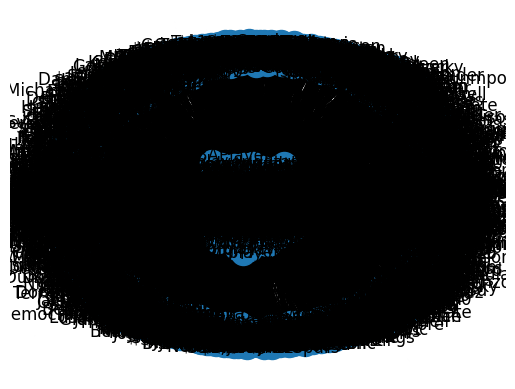

In [25]:
# pos = nx.spring_layout(G, scale=4)
# edge_labels = nx.get_edge_attributes(G, 'r')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# nx.draw(G, with_labels=True)
# plt.show()

In [35]:
def turtle_to_dot(turtle_file, dot_file):
    # Create an RDF graph and parse the Turtle file
    graph = Graph()
    graph.parse(turtle_file, format="turtle")

    # Create a DOT file and write the header
    with open(dot_file, "w") as f:
        f.write("digraph G {\n")
        f.write('    node [shape=box];\n')

        # Iterate over the triples and extract the relevant information
        for s, p, o in graph:
            # Check if the triple is about an NBAPlayer
            if p == RDF.type and o == nba_namespace.NBAPlayer:
                player_uri = s

                # Get the full_name of the player
                full_name = str(graph.value(s, nba_namespace.full_name))

                # Get the team the player is in
                team = str(graph.value(s, nba_namespace.team))

                # Get the height and weight of the player (assuming they are stored as xsd:float literals)
                height = str(graph.value(s, nba_namespace.height))
                weight = str(graph.value(s, nba_namespace.weight))

                # Get the salary of the player
                salary = str(graph.value(s, nba_namespace.salary))

                # Get the country of the player
                country = str(graph.value(s, nba_namespace.country))

                # Write the node and edges to the DOT file
                f.write(f'    "{full_name}" -> "{team}" [label="currentTeam"];\n')
                f.write(f'    "{full_name}" -> "{height}" [label="hasHeight"];\n')
                f.write(f'    "{full_name}" -> "{weight}" [label="hasWeight"];\n')
                f.write(f'    "{full_name}" -> "{salary}" [label="has yearSalaryOf"];\n')
                f.write(f'    "{full_name}" -> "{country}" [label="from"];\n')

        # Write the DOT file footer
        f.write("}")


# Replace "input.ttl" with the path to your Turtle file
turtle_to_dot("nba-players-2.ttl", "docs/output.dot")